In [10]:
import os
import pandas as pd

base_path = r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity\CAMELS_V2.2"

# Read gauge-basin mapping
df_summary = pd.read_csv(rf'{base_path}\attributes_csv\camels_ind_name.csv')
df_basin_map = df_summary[["gauge_id", "river_basin", "flow_availability"]]
df_basin_map = df_basin_map[df_basin_map["flow_availability"] >= 90].copy()

# Read area info
df_attributes = pd.read_csv(rf'{base_path}\attributes_csv\camels_ind_topo.csv')[["gauge_id", "cwc_area"]]
df_basin_map = pd.merge(df_basin_map, df_attributes, on="gauge_id", how="left")

# Read streamflow data
streamflow_df = pd.read_csv(rf'{base_path}\streamflow_timeseries\streamflow_observed.csv')
streamflow_df["Date"] = pd.to_datetime(streamflow_df[["year", "month", "day"]])
streamflow_df = streamflow_df[(streamflow_df["Date"] >= "1980-01-01") & (streamflow_df["Date"] <= "2018-12-31")]
streamflow_df.fillna(method='ffill', inplace=True)
streamflow_df.fillna(method='bfill', inplace=True)

# Dictionary to collect data by basin
basin_data = {}

for _, row in df_basin_map.iterrows():
    gauge_id = row["gauge_id"]
    basin = row["river_basin"]
    area = row["cwc_area"]
    file_path = f'{base_path}/catchment_mean_forcings/{gauge_id:05d}.csv'

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    precip_df = pd.read_csv(file_path)
    precip_df["Date"] = pd.to_datetime(precip_df[["year", "month", "day"]])
    precip_df = precip_df[(precip_df["Date"] >= "1980-01-01") & (precip_df["Date"] <= "2018-12-31")]

    # --- Prepare streamflow in mm/day ---
    if str(gauge_id) not in streamflow_df.columns:
        continue  # skip if no streamflow

    stream_mm = streamflow_df[['Date', 'year', 'month', 'day', str(gauge_id)]].copy()
    stream_mm[str(gauge_id)] = stream_mm[str(gauge_id)] * 86400 / (area * 1000)

    # --- Annual sums ---
    annual_precip = precip_df.groupby('year')['prcp(mm/day)'].sum().reset_index().rename(columns={'prcp(mm/day)': 'Annual_P'})
    annual_AET = precip_df.groupby('year')['aet_gleam(mm/day)'].sum().reset_index().rename(columns={'aet_gleam(mm/day)': 'Annual_AET'})
    annual_streamflow = stream_mm.groupby('year')[str(gauge_id)].sum().reset_index().rename(columns={str(gauge_id): 'Annual_Q'})
    
    # Annual PET (assuming PET = AET for simplicity, or you can use another PET column if available)
    annual_PET = precip_df.groupby('year')['aet_gleam(mm/day)'].sum().reset_index().rename(columns={'aet_gleam(mm/day)': 'Annual_PET'})

    # --- Monsoon sums (June–Sept) ---
    monsoon_mask = (precip_df['Date'].dt.month >= 6) & (precip_df['Date'].dt.month <= 9)
    monsoon_precip = precip_df[monsoon_mask].groupby('year')['prcp(mm/day)'].sum().reset_index().rename(columns={'prcp(mm/day)': 'Msum_P'})
    monsoon_AET = precip_df[monsoon_mask].groupby('year')['aet_gleam(mm/day)'].sum().reset_index().rename(columns={'aet_gleam(mm/day)': 'Msum_AET'})
    monsoon_stream = stream_mm[monsoon_mask].groupby('year')[str(gauge_id)].sum().reset_index().rename(columns={str(gauge_id): 'Msum_Q'})
    
    # Monsoon PET
    monsoon_PET = precip_df[monsoon_mask].groupby('year')['aet_gleam(mm/day)'].sum().reset_index().rename(columns={'aet_gleam(mm/day)': 'Msum_PET'})

    # --- Merge year-based results ---
    merged = annual_streamflow.merge(annual_precip, on='year') \
                              .merge(annual_AET, on='year') \
                              .merge(annual_PET, on='year') \
                              .merge(monsoon_stream, on='year') \
                              .merge(monsoon_precip, on='year') \
                              .merge(monsoon_AET, on='year') \
                              .merge(monsoon_PET, on='year')
    merged = merged[merged["Annual_Q"] != 0]

    # --- Assign year type (wet, normal, dry) based on precipitation percentiles ---
    p25 = merged['Annual_P'].quantile(0.25)
    p75 = merged['Annual_P'].quantile(0.75)
    merged['year_type'] = merged['Annual_P'].apply(lambda x: 'dry' if x < p25 else ('wet' if x > p75 else 'normal'))

    # --- Long-term daily climatology (June 1 – Sept 30) ---
    # Precip
    precip_monsoon = precip_df[monsoon_mask].copy()
    precip_monsoon["doy"] = precip_monsoon["Date"].dt.strftime("%m-%d")
    ltm_P = precip_monsoon.groupby("doy")["prcp(mm/day)"].mean().reset_index()

    # AET
    aet_monsoon = precip_df[monsoon_mask].copy()
    aet_monsoon["doy"] = aet_monsoon["Date"].dt.strftime("%m-%d")
    ltm_AET = aet_monsoon.groupby("doy")["aet_gleam(mm/day)"].mean().reset_index()

    # PET climatology (same as AET)
    ltm_PET = ltm_AET.rename(columns={"aet_gleam(mm/day)": "ltm_PET"})

    # Q
    stream_monsoon = stream_mm[monsoon_mask].copy()
    stream_monsoon["doy"] = stream_monsoon["Date"].dt.strftime("%m-%d")
    ltm_Q = stream_monsoon.groupby("doy")[str(gauge_id)].mean().reset_index()

    # Merge LTM climatology
    ltm_df = ltm_Q.merge(ltm_P, on="doy").merge(ltm_AET, on="doy").merge(ltm_PET, on="doy")
    ltm_df.rename(columns={
        str(gauge_id): "ltm_Q",
        "prcp(mm/day)": "ltm_P",
        "aet_gleam(mm/day)": "ltm_AET"
    }, inplace=True)

    # --- Save both merged (39 years) and ltm (122 days) in same sheet ---
    out_df = pd.concat([merged.reset_index(drop=True), ltm_df.reset_index(drop=True)], axis=1)

    # Store in basin dictionary
    if basin not in basin_data:
        basin_data[basin] = {}
    basin_data[basin][str(gauge_id)] = out_df

# --- Save to Excel files ---
for basin, gauges in basin_data.items():
    with pd.ExcelWriter(rf"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity\Q\{basin}.xlsx") as writer:
        for gauge_id, df in gauges.items():
            df.to_excel(writer, sheet_name=str(gauge_id), index=False)


C:\Users\User\AppData\Local\Temp\ipykernel_45532\3778399123.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  streamflow_df.fillna(method='ffill', inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_45532\3778399123.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  streamflow_df.fillna(method='bfill', inplace=True)


In [1]:
import os
import pickle
import pandas as pd

# ------------------------
# PATHS
# ------------------------
data_dir = r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity"
trace_dir = os.path.join(data_dir, "traces_bayes")
qdata_dir = os.path.join(data_dir, "Q")
summary_file = os.path.join(data_dir, "Basin_Station_Summary.xlsx")

# ------------------------
# Load metadata
# ------------------------
df_meta = pd.read_excel(summary_file, sheet_name="Sheet1")

# ------------------------
# Load Msum traces
# ------------------------
msum_file = os.path.join(trace_dir, "MonsoonSum_trace.pkl")
with open(msum_file, "rb") as f:
    traces = pickle.load(f)

def build_trace_lookup(traces):
    lookup = {}
    for idata in traces:
        gid = str(idata.gauge_info["Gauge_id"].values[0])
        lookup[gid] = idata
    return lookup

trace_lookup = build_trace_lookup(traces)

# ------------------------
# Find valid gauges per basin
# ------------------------
basins = ["Cauvery", "Mahanadi", "Krishna", "Godavari"]
available_gauges = {}

for basin in basins:
    basin_gauges = df_meta.loc[df_meta["Basin"] == basin, "Gauge_ID"].astype(str)

    valid = []
    for gauge in basin_gauges:
        # check trace exists
        if gauge not in trace_lookup:
            continue

        # check Excel sheet exists
        basin_file = os.path.join(qdata_dir, f"{basin}.xlsx")
        if not os.path.exists(basin_file):
            continue

        try:
            df_g = pd.read_excel(basin_file, sheet_name=gauge, nrows=1)
            if "year_type" not in df_g.columns:
                continue
            valid.append(gauge)
        except:
            continue

    available_gauges[basin] = valid

# ------------------------
# PRINT RESULT
# ------------------------
for basin, gauges in available_gauges.items():
    print(f"\n{basin} → {len(gauges)} usable gauges:")
    print(gauges)

C:\Users\User\.conda\envs\myenv\Lib\site-packages\arviz\__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(



Cauvery → 11 usable gauges:
['5002', '5007', '5008', '5010', '5013', '5014', '5018', '5022', '5027', '5028', '5029']

Mahanadi → 13 usable gauges:
['8001', '8003', '8005', '8006', '8009', '8011', '8013', '8016', '8020', '8031', '8035', '8036', '8038']

Krishna → 15 usable gauges:
['4004', '4007', '4013', '4017', '4021', '4022', '4026', '4031', '4038', '4050', '4054', '4061', '4062', '4063', '4064']

Godavari → 10 usable gauges:
['3005', '3008', '3018', '3045', '3055', '3068', '3071', '3073', '3075', '3103']


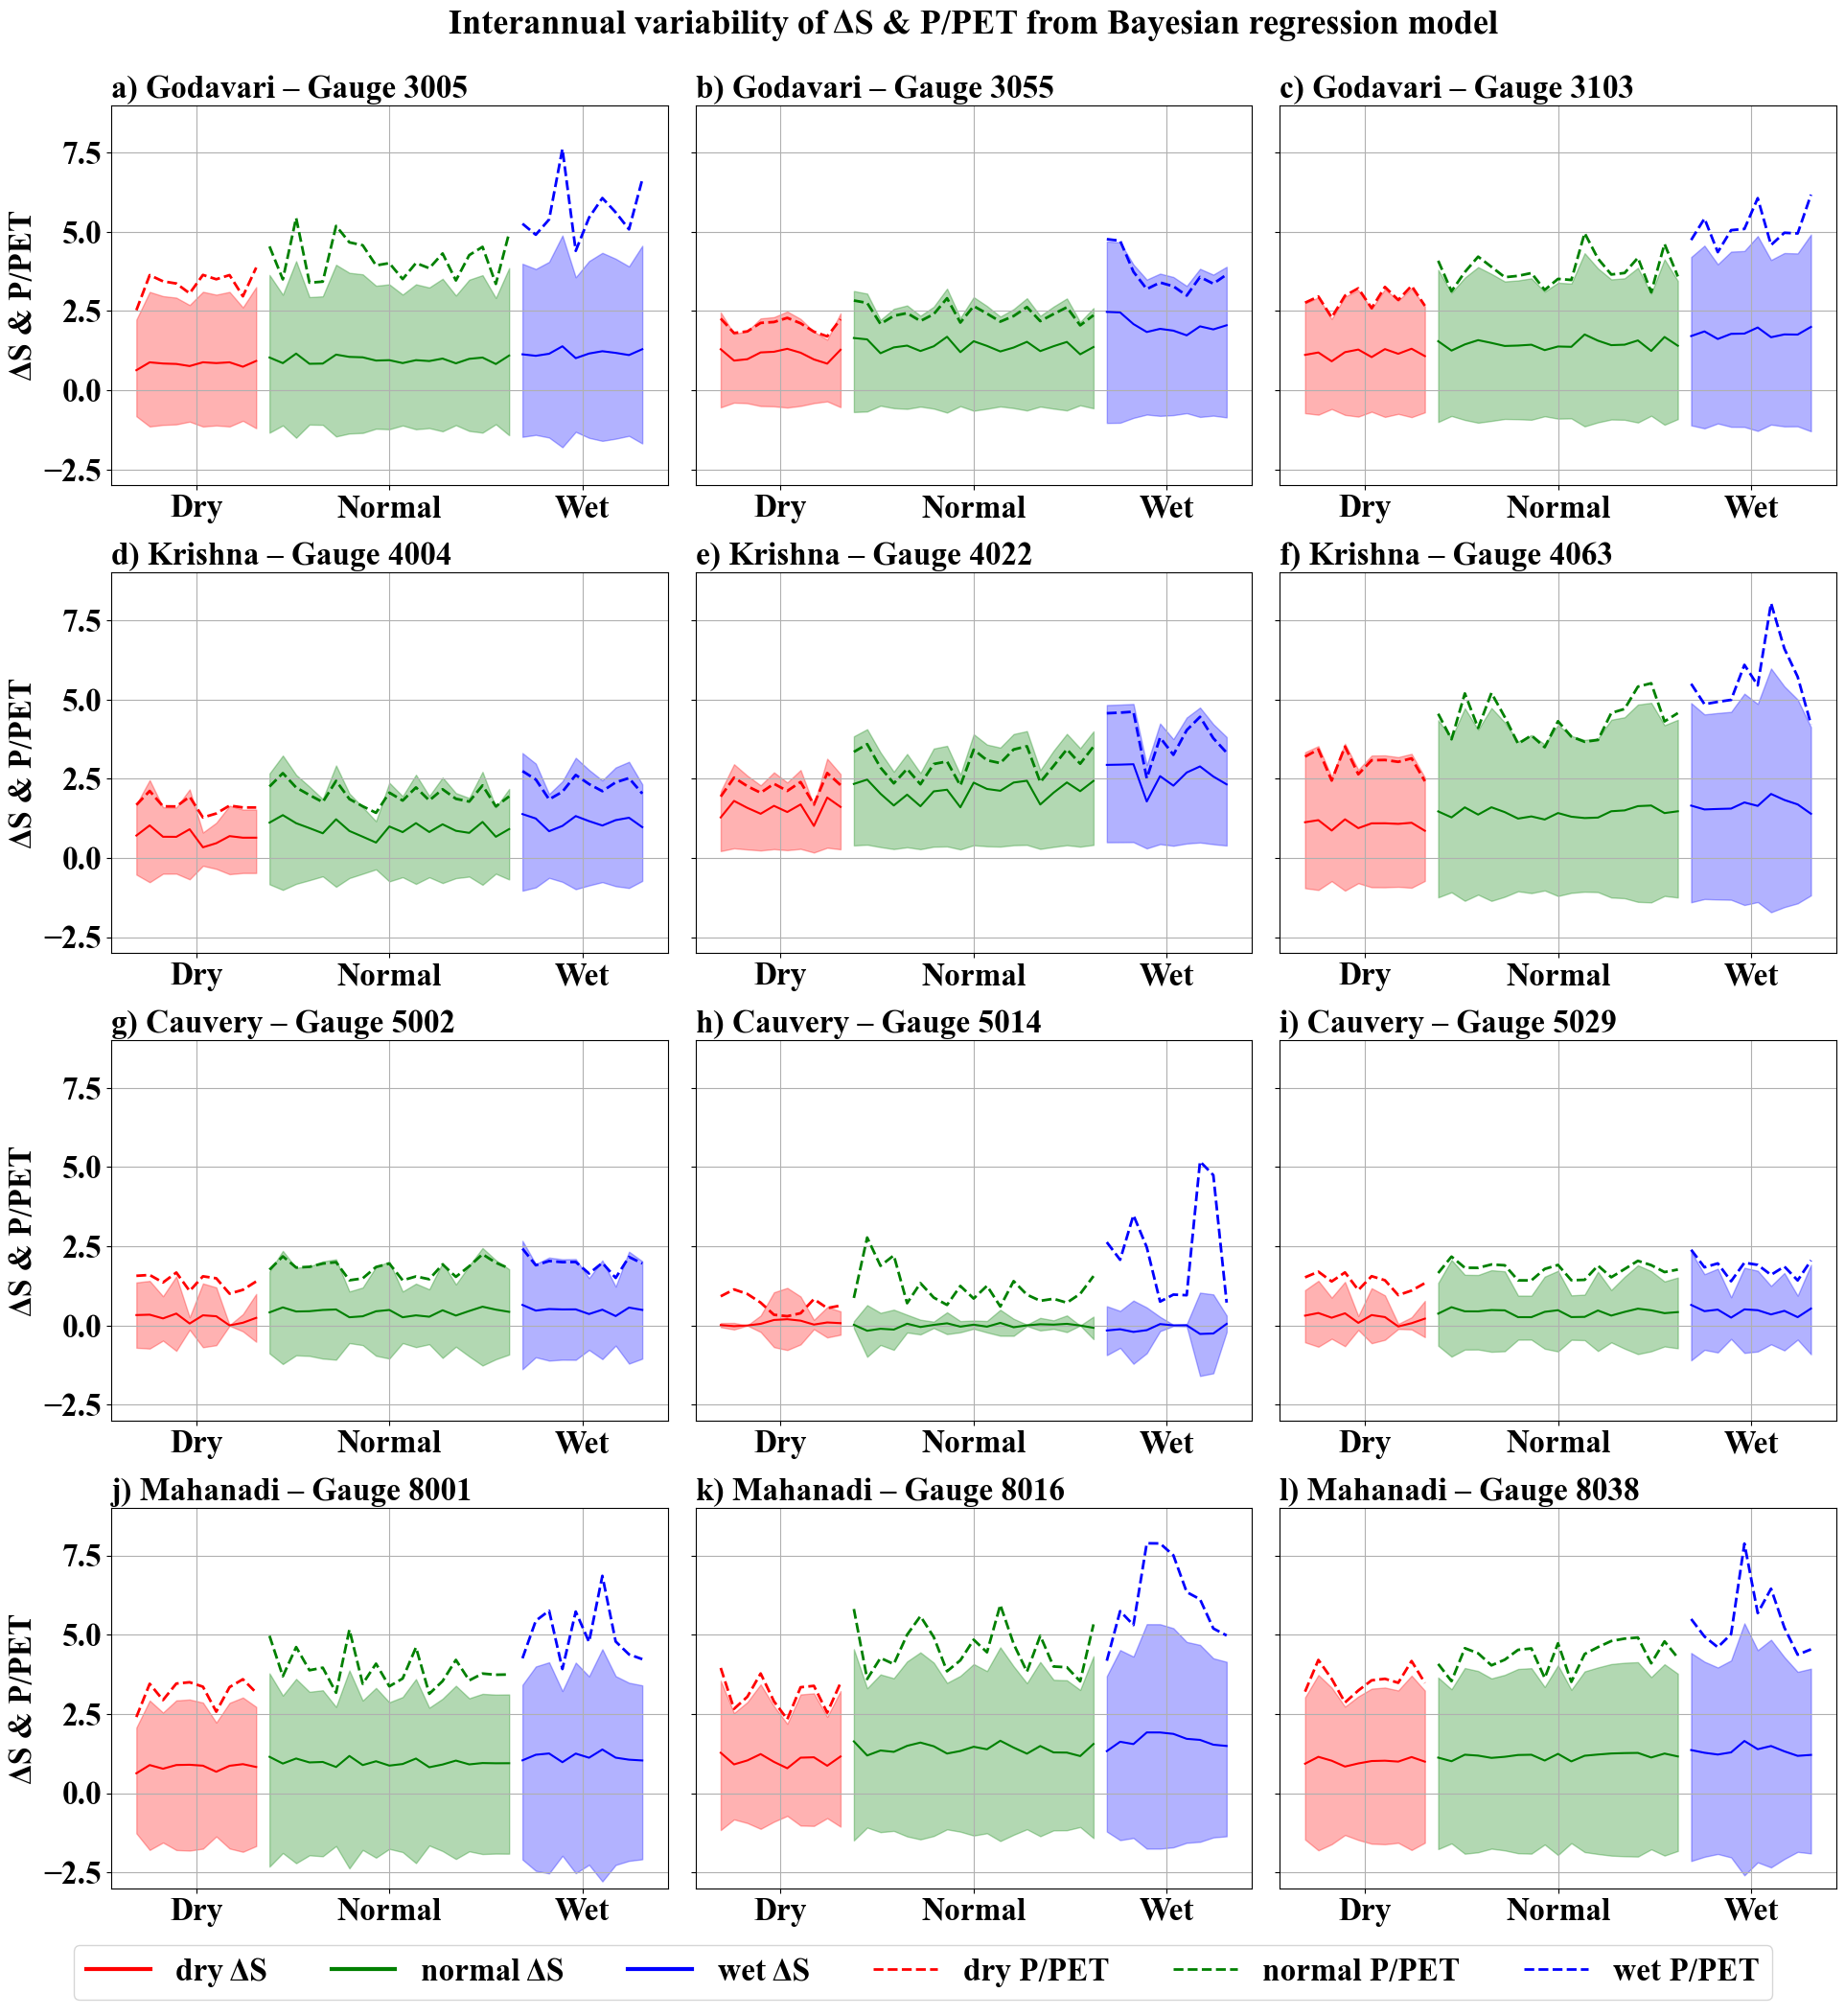

In [20]:
import os
import pickle
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["font.family"] = "Times New Roman"
import string
panel_labels = list(string.ascii_lowercase)
panel_counter = 0
# ------------------------
# PATHS
# ------------------------
data_dir = r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity"
trace_dir = os.path.join(data_dir, "traces_bayes")
qdata_dir = os.path.join(data_dir, "Q")
summary_file = os.path.join(data_dir, "Basin_Station_Summary.xlsx")

# ------------------------
# Load station metadata
# ------------------------
df_meta = pd.read_excel(summary_file, sheet_name="Sheet1")

# ------------------------
# Load Msum traces
# ------------------------
msum_file = os.path.join(trace_dir, "MonsoonSum_trace.pkl")
with open(msum_file, "rb") as f:
    traces = pickle.load(f)

# ------------------------
# Helper: Gauge_ID → idata
# ------------------------
def build_trace_lookup(traces):
    lookup = {}
    for idata in traces:
        gid = str(idata.gauge_info["Gauge_id"].values[0])
        lookup[gid] = idata
    return lookup

trace_lookup = build_trace_lookup(traces)

# ------------------------
# Select gauges per basin
# ------------------------
gauges_to_plot = {
    "Godavari": ["3005", "3055", "3103"],
    "Krishna": ['4004', '4022', '4063'],
    "Cauvery": ['5002', '5014', '5029'],  
    "Mahanadi": ["8001", "8016", "8038"]
}

# ------------------------
# Prepare delta_S per year_type
# ------------------------
delta_s_traces = {}

for basin, gauges in gauges_to_plot.items():
    delta_s_traces[basin] = {}

    for gauge in gauges:
        if gauge not in trace_lookup:
            continue

        idata = trace_lookup[gauge]
        beta_s_samples = idata.posterior["beta_S"].values.reshape(-1)

        df_gauge = pd.read_excel(
            os.path.join(qdata_dir, f"{basin}.xlsx"),
            sheet_name=gauge
        )

        P = df_gauge["Msum_P"].values
        AET = df_gauge["Msum_AET"].values
        PET = df_gauge["Msum_PET"].values
        year_type = df_gauge["year_type"].values
        years = df_gauge["year"].values

        valid = (P > 0) & (AET > 0) & (PET > 0)
        P, AET, PET, year_type, years = (
            P[valid], AET[valid], PET[valid],
            year_type[valid], years[valid]
        )

        delta_s_all = np.array([b * np.log(P / AET) for b in beta_s_samples])
        humidity_all = P / PET

        delta_s_traces[basin][gauge] = {}

        for ytype in ["wet", "normal", "dry"]:
            mask = (year_type == ytype)

            if mask.sum() == 0:
                delta_s_traces[basin][gauge][ytype] = None
                continue

            delta_s_traces[basin][gauge][ytype] = {
                "years": years[mask],
                "samples": delta_s_all[:, mask],
                "humidity": humidity_all[mask]
            }

# ------------------------
# PLOT: dynamic layout
# ------------------------
basins = list(gauges_to_plot.keys())
n_rows = len(basins)
n_cols = max(len(gauges_to_plot[b]) for b in basins)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(6*n_cols, 5*n_rows),
    sharey=True
)

if n_rows == 1:
    axes = np.array([axes])
if n_cols == 1:
    axes = axes.reshape(n_rows, 1)

colors = {"wet": "blue", "normal": "green", "dry": "red"}
order = ["dry", "normal", "wet"]

for row_idx, basin in enumerate(basins):
    for col_idx in range(n_cols):

        ax = axes[row_idx, col_idx]

        if col_idx >= len(gauges_to_plot[basin]):
            ax.axis("off")
            continue
        gauge = gauges_to_plot[basin][col_idx]
        traces_by_type = delta_s_traces[basin].get(gauge, {})

        # ⭐ CREATE LABEL HERE (always runs for real panels)
        panel_label = f"{panel_labels[panel_counter]})"
        panel_counter += 1

        x_cursor = 0
        xticks = []
        xticklabels = []

        for ytype in order:
            data = traces_by_type.get(ytype)
            if data is None:
                continue

            years = data["years"]
            samples = data["samples"]
            humidity = data["humidity"]

            sort_idx = np.argsort(years)
            years = years[sort_idx]
            samples = samples[:, sort_idx]
            humidity = humidity[sort_idx]

            mean_vals = np.nanmean(samples, axis=0)
            hdi_lower = np.nanpercentile(samples, 5, axis=0)
            hdi_upper = np.nanpercentile(samples, 95, axis=0)

            x_vals = np.arange(x_cursor, x_cursor + len(years))

            # ΔS band
            ax.plot(x_vals, mean_vals, color=colors[ytype])
            ax.fill_between(x_vals, hdi_lower, hdi_upper,
                            color=colors[ytype], alpha=0.3)

            # Humidity index dashed line
            ax.plot(x_vals, humidity,
                    linestyle="--",
                    linewidth=2,
                    color=colors[ytype])

            xticks.append(x_vals.mean())
            xticklabels.append(ytype[:1].upper() + ytype[1:])

            x_cursor += len(years)

        # formatting
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels, fontsize=24, fontweight="bold")

        ax.set_title(f"{panel_label} {basin} – Gauge {gauge}",
             fontsize=24, fontweight="bold", loc="left")
        
        if col_idx == 0:
            ax.set_ylabel("ΔS & P/PET",
                          fontsize=24, fontweight="bold")

        ax.tick_params(axis='y', labelsize=24)
        for label in ax.get_yticklabels():
            label.set_fontweight('bold')

        ax.grid(True)

        # ✅ ADD THIS
        ax.set_ylim(-3, 9)

# ------------------------
# Global legend
# ------------------------
handles = [
    plt.Line2D([0], [0], color=colors[k], lw=3, label=f"{k} ΔS")
    for k in order
] + [
    plt.Line2D([0], [0], color=colors[k], lw=2, linestyle="--", label=f"{k} P/PET")
    for k in order
]

legend = fig.legend(
    handles=handles,
    loc="lower center",
    ncol=6,
    fontsize=24,
    frameon=True)

legend.get_title().set_fontweight('bold')
for text in legend.get_texts():
    text.set_fontweight('bold')
    
fig.suptitle(f"Interannual variability of ΔS & P/PET from Bayesian regression model", fontsize=26, 
             fontweight='bold', x=0.5, y=1.05)

# plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.subplots_adjust(left=0, right=1, top=1, bottom=0.07, wspace=0.05, hspace = 0.23)
plt.savefig(r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity\spatial plots\wet_dry_BR.png", dpi=330, bbox_inches="tight")
plt.show()


In [3]:
import os
import pickle

trace_file = r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity\traces\BH_Mahanadi_Long-term average.pkl"

with open(trace_file, "rb") as f:
    idata = pickle.load(f)

print("Object type:", type(idata))

print("\nAvailable groups:")
print(idata.groups())

print("\nPosterior variables:")
print(list(idata.posterior.data_vars))

print("\nPosterior dimensions:")
print(idata.posterior.dims)

print("\nSample stats variables:")
print(list(idata.sample_stats.data_vars))

print("\nGauge info:")
print(idata.gauge_info)
print("Groups and sizes:")
for g in idata.groups():
    print(g, getattr(idata, g))


Object type: <class 'arviz.data.inference_data.InferenceData'>

Available groups:
['posterior', 'log_likelihood', 'sample_stats', 'observed_data']

Posterior variables:
['mu_beta', 'beta', 'delta_S', 'W', 'mu_alpha', 'mu_epsilon', 'sigma_alpha', 'sigma_epsilon', 'sigma_beta', 'alpha', 'epsilon', 'sigma_Q', 'sigma_S', 'sigma_W', 'log_Q_nat', 'log_Q_pred', 'Q_pred']

Posterior dimensions:
FrozenMappingWarningOnValuesAccess({'chain': 3, 'draw': 1000, 'beta_dim_0': 13, 'delta_S_dim_0': 122, 'delta_S_dim_1': 13, 'W_dim_0': 122, 'W_dim_1': 13, 'alpha_dim_0': 13, 'epsilon_dim_0': 13, 'log_Q_nat_dim_0': 122, 'log_Q_nat_dim_1': 13, 'log_Q_pred_dim_0': 122, 'log_Q_pred_dim_1': 13, 'Q_pred_dim_0': 122, 'Q_pred_dim_1': 13})

Sample stats variables:
['index_in_trajectory', 'energy_error', 'diverging', 'step_size_bar', 'perf_counter_diff', 'smallest_eigval', 'max_energy_error', 'energy', 'process_time_diff', 'acceptance_rate', 'step_size', 'tree_depth', 'perf_counter_start', 'lp', 'reached_max_treed

AttributeError: 'InferenceData' object has no attribute 'gauge_info'

In [2]:
import os
import pandas as pd

# ------------------------
# PATHS
# ------------------------
data_dir = r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity"
qdata_dir = os.path.join(data_dir, "Q")
summary_file = os.path.join(data_dir, "Basin_Station_Summary.xlsx")

# ------------------------
# Load metadata
# ------------------------
df_meta = pd.read_excel(summary_file, sheet_name="Msum_sites")

# ------------------------
# Basins to check
# ------------------------
basins = ["Godavari", "Krishna", "Cauvery", "Mahanadi"]

available_gauges = {}

for basin in basins:
    basin_file = os.path.join(qdata_dir, f"{basin}.xlsx")

    if not os.path.exists(basin_file):
        available_gauges[basin] = []
        continue

    basin_gauges = (
        df_meta.loc[df_meta["Basin"] == basin, "Gauge_ID"]
        .astype(str)
        .values
    )

    valid = []

    for gauge in basin_gauges:
        try:
            df_g = pd.read_excel(basin_file, sheet_name=gauge, nrows=1)

            if "year_type" in df_g.columns:
                valid.append(gauge)

        except:
            continue

    available_gauges[basin] = valid

# ------------------------
# PRINT RESULT
# ------------------------
for basin, gauges in available_gauges.items():
    print(f"\n{basin} → {len(gauges)} usable gauges:")
    print(gauges)



Godavari → 9 usable gauges:
['3005', '3008', '3018', '3045', '3055', '3068', '3073', '3075', '3103']

Krishna → 12 usable gauges:
['4004', '4007', '4017', '4021', '4022', '4026', '4031', '4038', '4061', '4062', '4063', '4064']

Cauvery → 9 usable gauges:
['5002', '5008', '5010', '5013', '5014', '5018', '5022', '5027', '5029']

Mahanadi → 13 usable gauges:
['8001', '8003', '8005', '8006', '8009', '8011', '8013', '8016', '8020', '8031', '8035', '8036', '8038']


Processing basin: Godavari
Processing basin: Krishna
Processing basin: Cauvery
Processing basin: Mahanadi


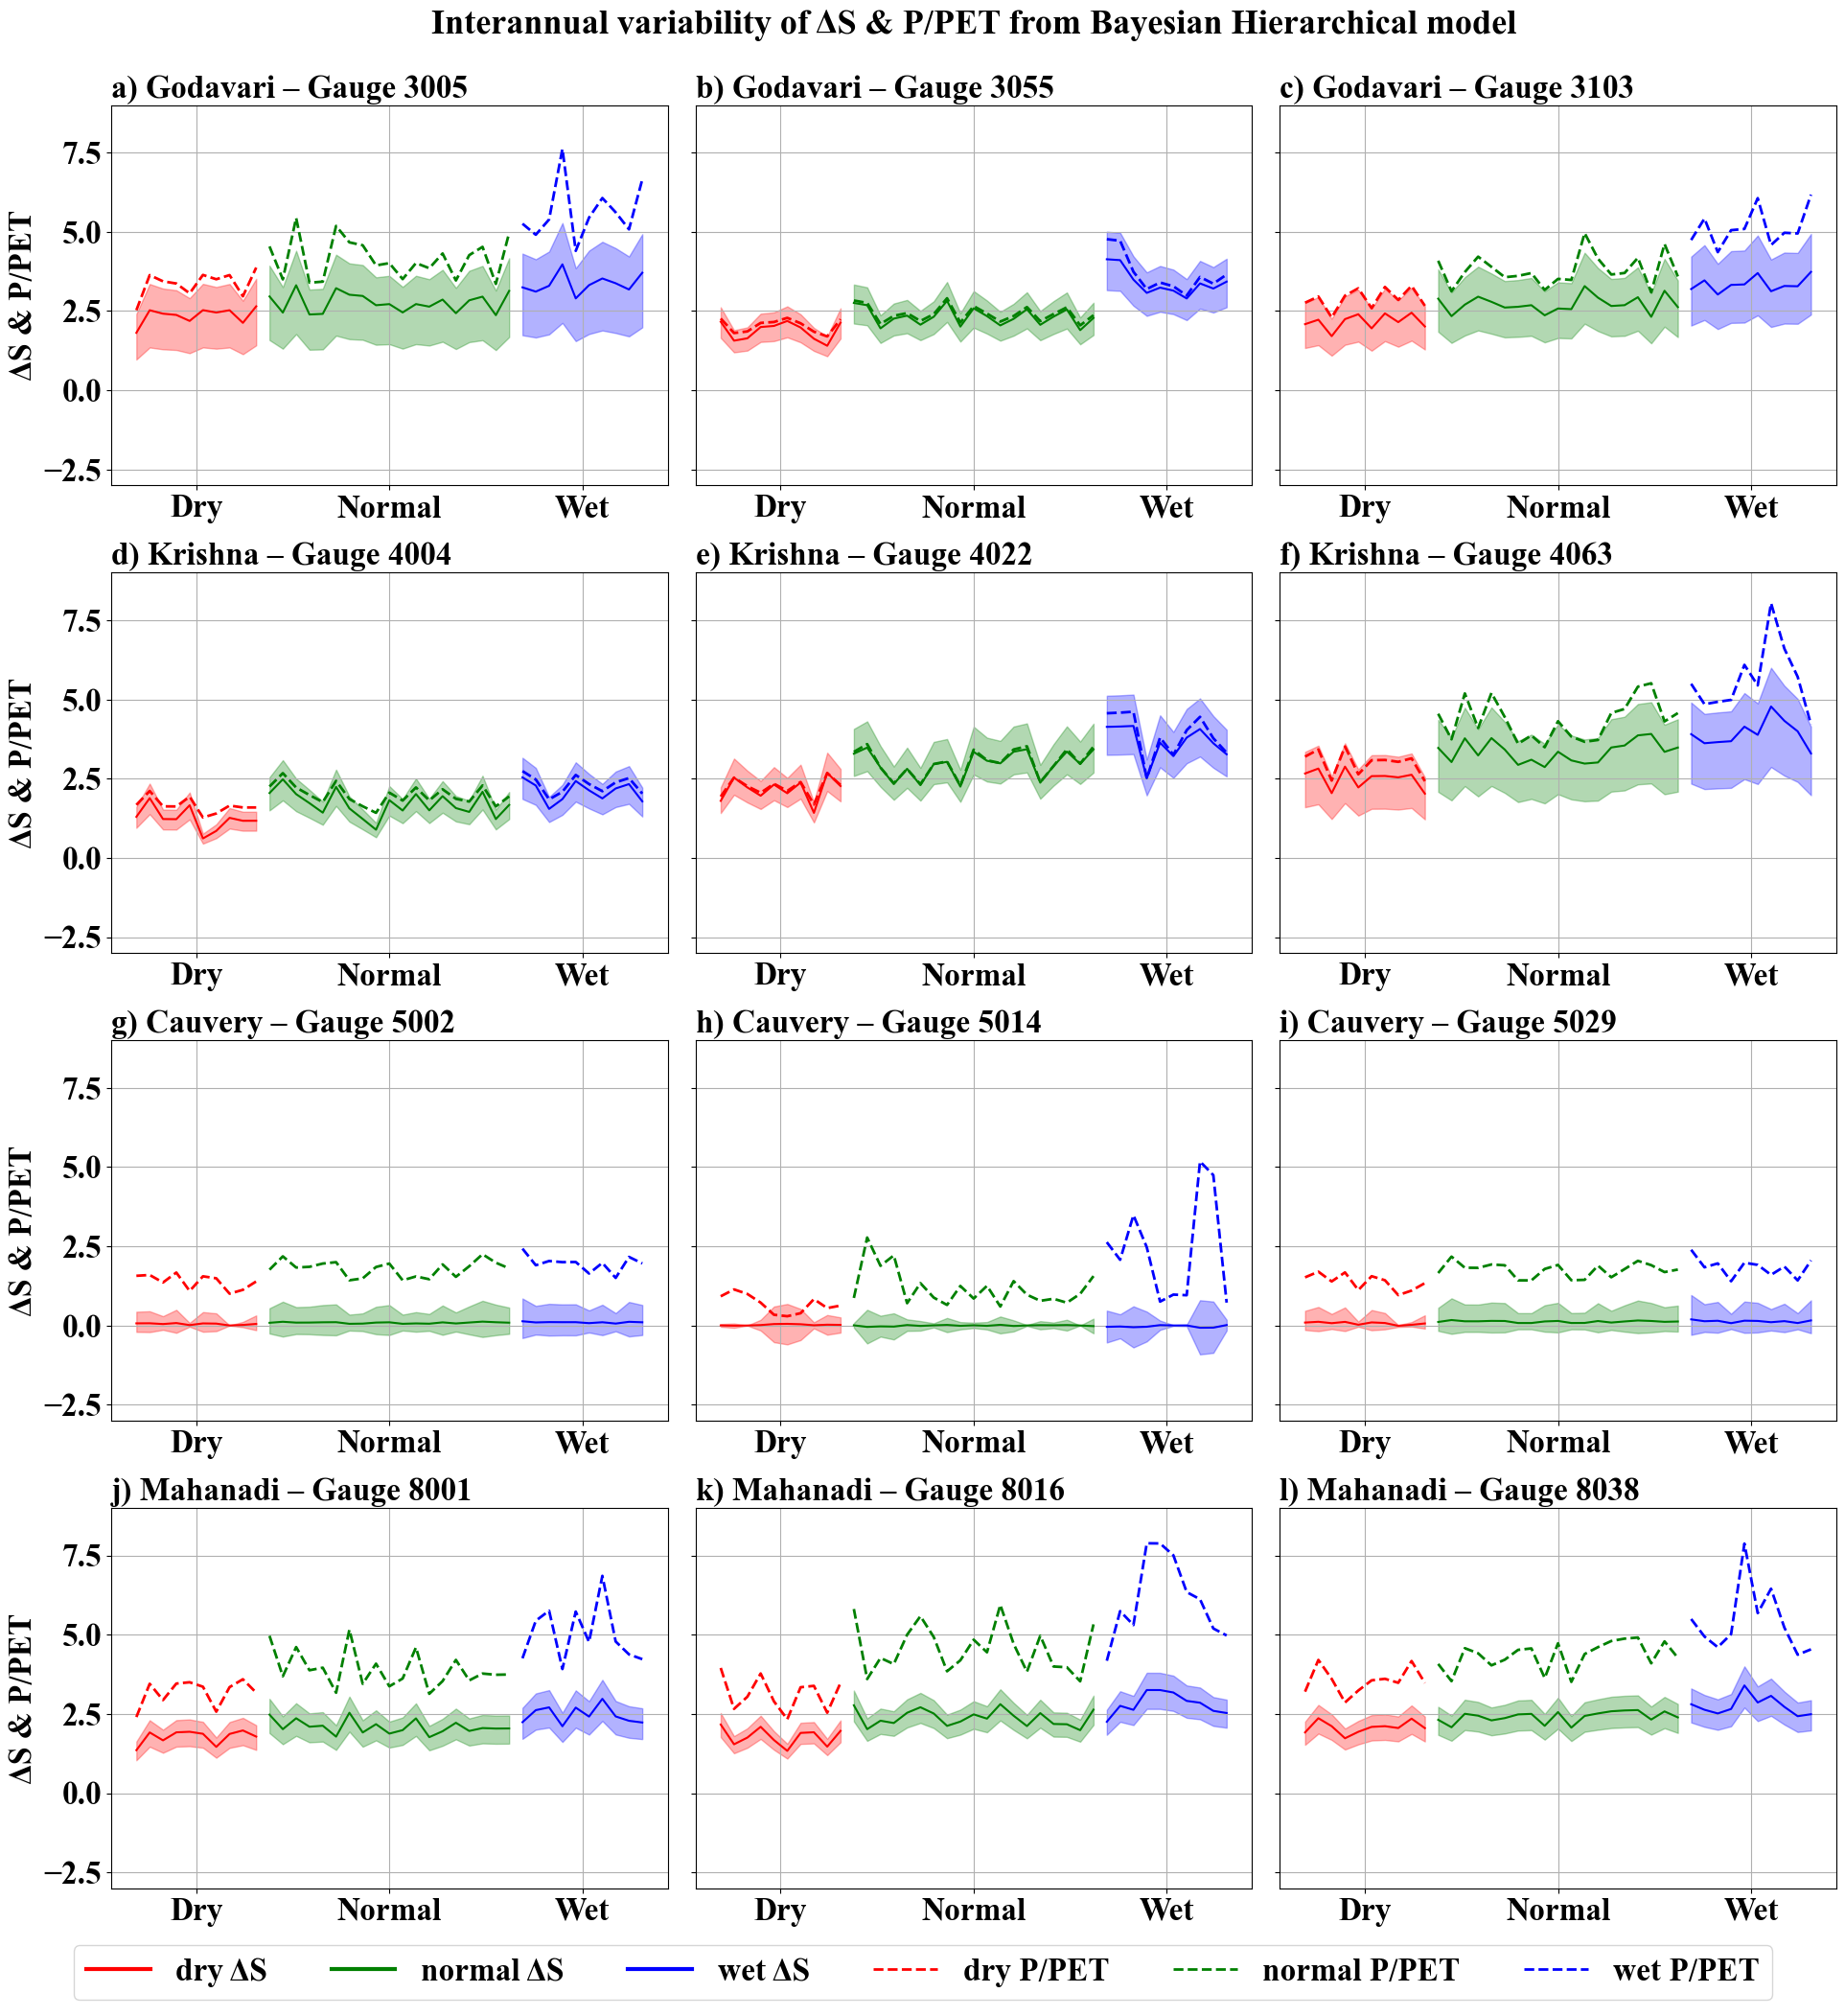

In [13]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
panel_labels = list(string.ascii_lowercase)
panel_counter = 0

# ------------------------
# PATHS
# ------------------------
data_dir = r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity"
trace_dir = os.path.join(data_dir, "traces")
qdata_dir = os.path.join(data_dir, "Q")
summary_file = os.path.join(data_dir, "Basin_Station_Summary.xlsx")

# ------------------------
# Load metadata (THIS defines gauge order in model)
# ------------------------
df_meta = pd.read_excel(summary_file, sheet_name="Msum_sites")

# ------------------------
# Hierarchical trace files
# ------------------------
trace_files = {
    "Godavari": "BH_Godavari_Monsoon_sum.pkl",
    "Krishna": "BH_Krishna_Monsoon_sum.pkl",
    "Cauvery": "BH_Cauvery_Monsoon_sum.pkl",
    "Mahanadi": "BH_Mahanadi_Monsoon_sum.pkl"
}

# ------------------------
# Gauges to plot
# ------------------------
gauges_to_plot = {
    "Godavari": ["3005", "3055", "3103"],
    "Krishna": ['4004', '4022', '4063'],
    "Cauvery": ['5002', '5014', '5029'],
    "Mahanadi": ["8001", "8016", "8038"]
}

# ------------------------
# Extract posterior ΔS from hierarchical model
# ------------------------
delta_s_traces = {}

for basin in gauges_to_plot.keys():

    print(f"Processing basin: {basin}")

    trace_path = os.path.join(trace_dir, trace_files[basin])
    with open(trace_path, "rb") as f:
        idata = pickle.load(f)

    # station order used in model
    basin_meta = df_meta[df_meta["Basin"] == basin]
    station_labels = basin_meta["Gauge_ID"].astype(str).values

    # posterior beta samples
    beta_samples = idata.posterior["beta"].values
    beta_samples = beta_samples.reshape(-1, len(station_labels))

    delta_s_traces[basin] = {}

    for gauge in gauges_to_plot[basin]:

        if gauge not in station_labels:
            continue

        g_idx = list(station_labels).index(gauge)
        beta_g_samples = beta_samples[:, g_idx]

        df_gauge = pd.read_excel(
            os.path.join(qdata_dir, f"{basin}.xlsx"),
            sheet_name=gauge
        )

        P = df_gauge["Msum_P"].values
        AET = df_gauge["Msum_AET"].values
        PET = df_gauge["Msum_PET"].values
        year_type = df_gauge["year_type"].values
        years = df_gauge["year"].values

        valid = (P > 0) & (AET > 0) & (PET > 0)
        P, AET, PET, year_type, years = (
            P[valid], AET[valid], PET[valid],
            year_type[valid], years[valid]
        )

        # compute posterior ΔS samples
        delta_s_all = np.array([
            b * np.log(P / AET) for b in beta_g_samples
        ])

        aridity = P / PET

        delta_s_traces[basin][gauge] = {}

        for ytype in ["wet", "normal", "dry"]:
            mask = (year_type == ytype)

            if mask.sum() == 0:
                delta_s_traces[basin][gauge][ytype] = None
                continue

            delta_s_traces[basin][gauge][ytype] = {
                "years": years[mask],
                "samples": delta_s_all[:, mask],
                "aridity": aridity[mask]
            }

# ------------------------
# PLOT
# ------------------------
basins = list(gauges_to_plot.keys())
n_rows = len(basins)
n_cols = max(len(gauges_to_plot[b]) for b in basins)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(6*n_cols, 5*n_rows),
    sharey=True
)

if n_rows == 1:
    axes = np.array([axes])
if n_cols == 1:
    axes = axes.reshape(n_rows, 1)

colors = {"wet": "blue", "normal": "green", "dry": "red"}
order = ["dry", "normal", "wet"]

for row_idx, basin in enumerate(basins):
    for col_idx in range(n_cols):

        ax = axes[row_idx, col_idx]

        # skip empty panels
        if col_idx >= len(gauges_to_plot[basin]):
            ax.axis("off")
            continue

        gauge = gauges_to_plot[basin][col_idx]
        traces_by_type = delta_s_traces[basin].get(gauge, {})

        # ⭐ CREATE LABEL HERE (always runs for real panels)
        panel_label = f"{panel_labels[panel_counter]})"
        panel_counter += 1
            
        gauge = gauges_to_plot[basin][col_idx]
        traces_by_type = delta_s_traces[basin].get(gauge, {})

        x_cursor = 0
        xticks = []
        xticklabels = []

        for ytype in order:
            data = traces_by_type.get(ytype)
            if data is None:
                continue

            years = data["years"]
            samples = data["samples"]
            aridity = data["aridity"]

            sort_idx = np.argsort(years)
            samples = samples[:, sort_idx]
            aridity = aridity[sort_idx]

            mean_vals = np.nanmean(samples, axis=0)
            hdi_lower = np.nanpercentile(samples, 5, axis=0)
            hdi_upper = np.nanpercentile(samples, 95, axis=0)

            x_vals = np.arange(x_cursor, x_cursor + len(mean_vals))

            ax.plot(x_vals, mean_vals, color=colors[ytype])
            ax.fill_between(x_vals, hdi_lower, hdi_upper,
                            color=colors[ytype], alpha=0.3)

            ax.plot(x_vals, aridity,
                    linestyle="--",
                    linewidth=2,
                    color=colors[ytype])

            xticks.append(x_vals.mean())
            xticklabels.append(ytype[:1].upper() + ytype[1:])
            x_cursor += len(mean_vals)
        # formatting
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels, fontsize=24, fontweight="bold")

        ax.set_title(f"{panel_label} {basin} – Gauge {gauge}",
             fontsize=24, fontweight="bold", loc="left")

        if col_idx == 0:
            ax.set_ylabel("ΔS & P/PET",
                          fontsize=24, fontweight="bold")

        ax.tick_params(axis='y', labelsize=24)
        for label in ax.get_yticklabels():
            label.set_fontweight('bold')

        ax.grid(True)

        # ✅ ADD THIS
        ax.set_ylim(-3, 9)

# ------------------------
# Global legend
# ------------------------
handles = [
    plt.Line2D([0], [0], color=colors[k], lw=3, label=f"{k} ΔS")
    for k in order
] + [
    plt.Line2D([0], [0], color=colors[k], lw=2, linestyle="--", label=f"{k} P/PET")
    for k in order
]

legend = fig.legend(
    handles=handles,
    loc="lower center",
    ncol=6,
    fontsize=24,
    frameon=True
)

legend.get_title().set_fontweight('bold')
for text in legend.get_texts():
    text.set_fontweight('bold')

fig.suptitle(f"Interannual variability of ΔS & P/PET from Bayesian Hierarchical model", fontsize=26, 
             fontweight='bold', x=0.5, y=1.05)
# plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.subplots_adjust(left=0, right=1, top=1, bottom=0.07, wspace=0.05, hspace = 0.23)
plt.savefig(
    r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity\spatial plots\wet_dry_BH.png",
    dpi=330, bbox_inches="tight")
plt.show()


In [34]:
from PIL import Image
import matplotlib.pyplot as plt

# ------------------------
# FILE PATHS
# ------------------------
img_left_path = r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity\spatial plots\wet_dry_BR.png"
img_right_path = r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity\spatial plots\wet_dry_BH.png"

legend_path = r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity\spatial plots\temp_legend.png"
output_path = r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity\spatial plots\Figure8_BR_vs_BH.png"

# ------------------------
# LEGEND (render as image)
# ------------------------
colors = {"wet": "blue", "normal": "green", "dry": "red"}
order = ["dry", "normal", "wet"]

handles = [
    plt.Line2D([0], [0], color=colors[k], lw=3, label=f"{k} ΔS")
    for k in order
] + [
    plt.Line2D([0], [0], color=colors[k], lw=2, linestyle="--", label=f"{k} P/PET")
    for k in order
]

fig_leg = plt.figure(figsize=(8, 1.2))
legend = fig_leg.legend(
    handles=handles,
    loc="center",
    ncol=6,
    fontsize=22,
    frameon=True
)

for text in legend.get_texts():
    text.set_fontweight("bold")

plt.axis("off")
plt.savefig(legend_path, dpi=400, bbox_inches="tight", pad_inches=0.2)
plt.close()

# ------------------------
# LOAD IMAGES
# ------------------------
img_left = Image.open(img_left_path)
img_right = Image.open(img_right_path)
legend_img = Image.open(legend_path)

# ------------------------
# MATCH HEIGHTS
# ------------------------
h = min(img_left.height, img_right.height)

img_left = img_left.resize(
    (int(img_left.width * h / img_left.height), h),
    Image.LANCZOS
)

img_right = img_right.resize(
    (int(img_right.width * h / img_right.height), h),
    Image.LANCZOS
)

# ------------------------
# CREATE CANVAS WITH LEGEND SPACE
# ------------------------
combined_width = img_left.width + img_right.width
combined_height = h + legend_img.height + 20  # spacing

combined = Image.new("RGB", (combined_width, combined_height), "white")

# paste panels
combined.paste(img_left, (0, 0))
combined.paste(img_right, (img_left.width, 0))

# center legend
legend_x = (combined_width - legend_img.width) // 2
legend_y = h + 12
combined.paste(legend_img, (legend_x, legend_y))

# ------------------------
# SAVE
# ------------------------
combined.save(output_path, dpi=(300, 300))
print("Merged figure with common legend saved →", output_path)


Merged figure with common legend saved → C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity\spatial plots\Figure8_BR_vs_BH.png
